In [77]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# Graph Similarity & TDA
**Author**: Bao Ngo

**Last updated** : 30 May

**Abstract**: Compare the similariry scores of 2 graphs before applying TDA transformation and after applying TDA method

**Description**: 
- `Similarity score` is calculated by implementing algorithm that can by find in this paper: https://www.cs.cmu.edu/~jingx/docs/DBreport.pdf

- Similarity test is conducted by compare the simmilarity score between 2 graphs before and after apply TDA method in the sample of graphs generating using `Erdos Renyl(ER) Model`





# Similarity score methods

**Find the smallest k such that the sum of the k largest eigenvalues constitutes at least 90% of the sum of all of the eigenvalues**

In [10]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

**Method to calculate similarity score between 2 graphs**

In [11]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity


# TDA methods

**Create data for TDA method by extracting 5 node features:**
 - `Pagerank`
 - `Degree centrality`
 - `Closeness centrality`
 - `Betweenes centrality `
 - `Clustering`


In [84]:
def extract_graph_features(graph):
    #pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    #pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    data = np.column_stack((dc_list,cc_list,bx_list,c_list))
    return data

**TDA tramsformation method, which take in graph represent data,extracting from each graph, and return a new graph**

In [13]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 5  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls, random_state=1618033),
        cover=km.Cover(n_cubes=2, perc_overlap=0.6))
    
    return km.to_nx(graph)

# Similarity test on TDA methods
**Method to conduct test similarity test on 2 graph**

*This method will return `true` if graphs after TDA transformation are more similar*

In [14]:
def is_TDA_capture_better(learning_graph, neighbour_graph):
    isBetter = False
    original_similarity_score = calculate_similarity(learning_graph,neighbour_graph)
    TDA_learning_graph = TDA_transformation(extract_graph_features(learning_graph))
    TDA_neighbour_graph = TDA_transformation(extract_graph_features(neighbour_graph))
    TDA_similarity_score = calculate_similarity(TDA_learning_graph,TDA_neighbour_graph)
    if(TDA_similarity_score < original_similarity_score ): isBetter = True
    return isBetter

**Method to conduct similarity test for each graph and their neighbour in the sample of graphs generating by using `ER model`**

*This method will return the fraction between the case that similarity score of two graphs after applying TDA transformation is `higher` and the total of similarity tests*

In [15]:
def compare_similarity_TDA_graph(n_low_bound,n_upper_bound,n_step, p_low_bound,p_upper_bound,p_step ):
    case_TDA_better = 0
    total_cases = 0
    n_range_length = round((n_upper_bound - n_low_bound)/n_step) + 1
    p_range_length = round((p_upper_bound - p_low_bound)/p_step) + 1
    
    for i in range(p_range_length):
        for j in range(n_range_length):
            n = n_low_bound + n_step*j
            p = p_low_bound + p_step*i
            target_graph = nx.erdos_renyi_graph(n,p)
            #Compare current graph with neighbour graphs
            if(i-1 >=0):
                p_neighbour = p_low_bound + p_step*(i-1)
                neighbour_graph = nx.erdos_renyi_graph(n,p_neighbour)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(i + 1 < p_range_length):
                p_neighbour = p_low_bound + p_step*(i+1)
                neighbour_graph = nx.erdos_renyi_graph(n,p_neighbour)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j - 1 >= 0):
                n_neighbour = n_low_bound + n_step*(j-1)
                neighbour_graph = nx.erdos_renyi_graph(n_neighbour,p)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j + 1 < n_range_length):
                n_neighbour = n_low_bound + n_step*(j+1)
                neighbour_graph = nx.erdos_renyi_graph(n_neighbour,p)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
                
    return case_TDA_better/total_cases

# Final result

*The fraction below is generating by conducting the sample of graphs generated by `ER model` with* 
 - ***[ 10,100 ]** and **10** are the range of n and increment step, respectively*
  - ***[ 0.1,0.9 ]** and **0.1** are the range of n and increment step, respectively*

In [18]:
score = compare_similarity_TDA_graph(n_low_bound = 10,n_upper_bound= 50,n_step = 10,p_low_bound = 0.1,p_upper_bound= 0.9,p_step = 0.1)
score

0.3881578947368421

In [76]:
graph = nx.erdos_renyi_graph(4,0.5)
graph2 = nx.erdos_renyi_graph(4,0.5)
nx.write_graphml(graph2,"graph2.hml")
score = calculate_similarity(graph,graph)
score

0.0

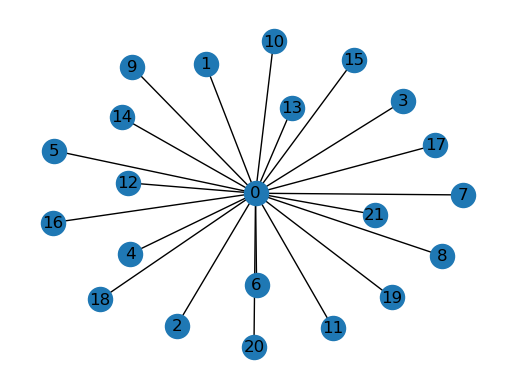

In [81]:
G = nx.star_graph(21)

# Plot the graph
pos = nx.spring_layout(G)  # Positions of the nodes for plotting
nx.draw_networkx(G, pos)
plt.axis('off')
plt.show()

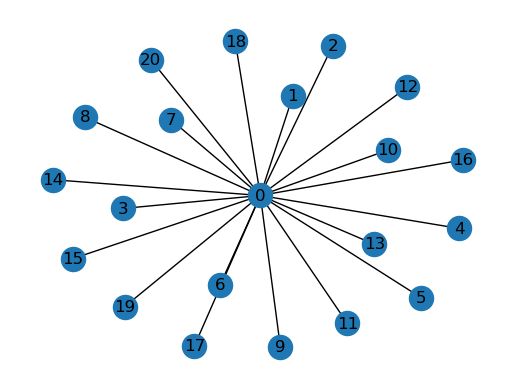

In [82]:
G1 = nx.star_graph(20)

# Plot the graph
pos = nx.spring_layout(G1)  # Positions of the nodes for plotting
nx.draw_networkx(G1, pos)
plt.axis('off')
plt.show()

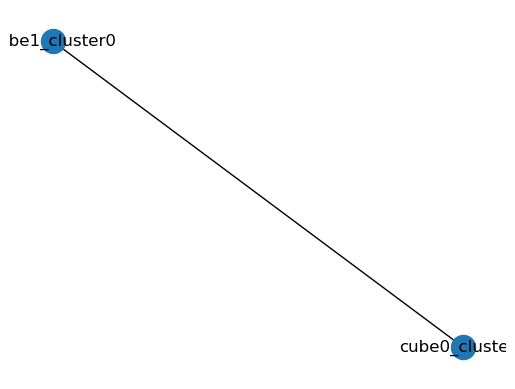

In [91]:
graph_TDA = TDA_transformation(extract_graph_features(G))
graph_TDA_1 =TDA_transformation(extract_graph_features(G1))
score = calculate_similarity(graph_TDA,graph_TDA_1)
pos = nx.spring_layout(graph_TDA_1)  # Positions of the nodes for plotting
nx.draw_networkx(graph_TDA_1, pos)
plt.axis('off')
plt.show()
